# Morphology versus environment from GAMA-KiDS Galaxy Zoo

This notebook examines the relationship between galaxy morphology (disk versus early-type) and environmental density, as a function of stellar mass, and compares with the corresponding relationship for colour (blue versus red divided by the optical bimodality). We aim to reproduce the main results in Bamford et al. (2009), which used Galaxy Zoo 1 data based on SDSS imaging. Compared to GZ1, GAMA-KiDS Galaxy Zoo uses a more complex, hierarchical question tree, which could cause apparent differences in the results. Therefore, as an intermediate step, we also examine data from Galaxy Zoo 2. This is based on the same SDSS imaging as GZ1, but with a question tree similar to that of GAMA-KiDS GZ.

## Notebook setup

In [1]:
%matplotlib inline

In [2]:
import os
import warnings
import shutil
import requests
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table, join, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import binom_conf_interval
from IPython.display import Image

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.figsize'] = (7.5, 6.0)
plt.rcParams['font.size'] = 16

## Catalogues

The following catalogues are used by this notebook. These should be downloaded and stored in `./data/` with their original filenames, for example using `wget URL --user=USER --password=PASSWD`.


#### GAMA-KIDS GZ

Note that the full GAMA catalogues are not yet public.

|Filename | Description | Download link | Further information |
|:------ |:------|:------:|:------:|
| gkgz-debiased | GAMA-KiDS Galaxy Zoo debiased morphologies | [download](https://github.com/leeskelvin/gamakidsgz/raw/master/outputs/gkgz-debiased.fits.gz) | [information](https://github.com/leeskelvin/gamakidsgz/blob/master/outputs/) |
| EnvironmentMeasuresv05 | GAMA environment measures | [download](http://www.gama-survey.org/data/cat/EnvironmentMeasures/v05/EnvironmentMeasuresv05.fits) | [information](http://www.gama-survey.org/db/schema/dmu.php?id=80) | |
| StellarMassesLambdarv20 | GAMA stellar masses |  [download](http://www.gama-survey.org/data/cat/StellarMasses/v20/StellarMassesLambdarv20.fits) | [information](http://www.gama-survey.org/db/schema/dmu.php?id=111) |

#### SDSS GZ1 and GZ2


|Filename | Description | Download link | Further information |
|:------ |:------|:------:|:------:|
| GalaxyZoo1_DR_extra.fits.gz | Galaxy Zoo 1 (SDSS) morphologies, plus ancilliary data | TBD | TBD |
| gz2_hart16.fits.gz |  Galaxy Zoo 2 (SDSS) debiased (Hart et al.) morphologies | [download](http://gz2hart.s3.amazonaws.com/gz2_hart16.fits.gz) | [information](https://data.galaxyzoo.org) |

The `GalaxyZoo1_DR_extra` catalogue contains the same morphological information as available from [data.galaxyzoo.org](https://data.galaxyzoo.org), along with a variety of anciliary data compiled for the analysis in Bamford et al. (2009). Key sources are listed below. However, the above catalogue includes some additional derived data, such as restframe absolute magnitudes.



### Data sources




|Filename | Description | Download link | Further information |
|:------ |:------|:------:|:------:|
| GalaxyZoo1_DR_table2.fits |  Galaxy Zoo 1 (SDSS) debiased morphologies | [download](http://galaxy-zoo-1.s3.amazonaws.com/GalaxyZoo1_DR_table2.fits) | [information](https://data.galaxyzoo.org) |
| dr7-densities.txt.gz | Baldry SDSS local densities | [download](https://www.astro.ljmu.ac.uk/~ikb/research/data/dr7-densities.txt.gz) | [information](https://www.astro.ljmu.ac.uk/~ikb/research/bimodality-paperIV.html)
| galSpecInfo-dr8.fits | MPA-JHU SDSS catalogue | [download](http://data.sdss3.org/sas/dr8/common/sdss-spectro/redux/galSpecInfo-dr8.fits) | [information](https://www.sdss.org/dr12/spectro/galaxy_mpajhu/) |
| galSpecExtra-dr8.fits | MPA-JHU SDSS stellar masses | [download](http://data.sdss3.org/sas/dr8/common/sdss-spectro/redux/galSpecExtra-dr8.fits) | [information](https://www.sdss.org/dr12/spectro/galaxy_mpajhu/) |

In [5]:
def get_gkgz_data(path="data"):
    table = Table.read(os.path.join(path, "gkgz-debiased.fits.gz"))
    env_table = Table.read(os.path.join(path, "EnvironmentMeasuresv05.fits"))
    del env_table["Z_TONRY"], env_table["nQ"]
    mass_table = Table.read(os.path.join(path, "StellarMassesLambdarv20.fits"))
    print(f"The original morphology catalogue contains {len(table)} objects")
    table = join(table, mass_table, keys='CATAID', metadata_conflicts='silent')
    print(f"After merging with the stellar mass table, {len(table)} remain")
    table = join(table, env_table, keys='CATAID', metadata_conflicts='silent')
    print(f"After merging with the environments table, {len(table)} remain")
    return table

In [6]:
gkgz_data = get_gkgz_data()

The original morphology catalogue contains 49866 objects
After merging with the stellar mass table, 49825 remain
After merging with the environments table, 48539 remain


In [7]:
def get_sdss_data_from_public(path="data"):
    # currently missing restframe photometry, not used
    mass_info = Table.read(os.path.join(path, "galSpecInfo-dr8.fits"))
    mass_extra = Table.read(os.path.join(path, "galSpecExtra-dr8.fits"))
    mass = hstack((mass_info[["RA", "DEC"]], mass_extra[["LGM_TOT_P16", "LGM_TOT_P50", "LGM_TOT_P84"]]))
    mass_ok = (mass_info["FIBERID"] >= 0) & (mass["RA"] > -999)
    mass = mass[mass_ok]
    mass_coord = SkyCoord(mass["RA"], mass["DEC"], unit="deg")
    env = Table.read(os.path.join("data", "dr7-densities.txt.gz"), format="ascii",
                       names=['objid', 'ra', 'dec', 'z', 'density', 'min_density', 'max_density'])
    env_coord = SkyCoord(env["ra"], env["dec"], unit="deg")
    idx, d2d, d3d = mass_coord.match_to_catalog_sky(env_coord)
    close = d2d < 1.0 * u.arcsec
    del env["ra"], env["dec"]
    env_matches = env[idx]
    table = hstack((mass, env_matches))
    return table

In [8]:
def get_gz1_data_from_public(sdss_data, path="data"):
    # not used
    table = Table.read(os.path.join(path, "GalaxyZoo1_DR_table2.fits"))
    print(f"The original morphology catalogue contains {len(table)} objects")
    gz_coord = SkyCoord(table["RA"], table["DEC"], unit=("hour", "deg"))
    sdss_coord = SkyCoord(sdss_data["RA"], sdss_data["DEC"], unit="deg")
    idx, d2d, d3d = gz_coord.match_to_catalog_sky(sdss_coord)
    close = d2d < 1.0 * u.arcsec
    del table["RA"], table["DEC"]
    sdss_matches = sdss_data[idx]
    table = hstack((table, sdss_matches))
    table = table[close]
    print(f"After merging with the SDSS table, {len(table)} remain")
    return table

In [9]:
def get_gz2_data_from_public(sdss_data, path="data"):
    # not used
    table = Table.read(os.path.join(path, "gz2_hart16.fits.gz"))
    print(f"The original morphology catalogue contains {len(table)} objects")
    gz_coord = SkyCoord(table["ra"], table["dec"], unit="deg")
    sdss_coord = SkyCoord(sdss_data["RA"], sdss_data["DEC"], unit="deg")
    idx, d2d, d3d = gz_coord.match_to_catalog_sky(sdss_coord)
    close = d2d < 1.0 * u.arcsec
    del table["ra"], table["dec"]
    sdss_matches = sdss_data[idx]
    table = hstack((table, sdss_matches))
    table = table[close]
    print(f"After merging with the SDSS table, {len(table)} remain")
    return table

In [10]:
def get_sdssgz_data(path="data"):
    gz1_table = Table.read(os.path.join(path, "GalaxyZoo1_DR_extra.fits.gz"))
    gz2_table = Table.read(os.path.join(path, "gz2_hart16.fits.gz"))
    gz2_table.rename_column('dr7objid', 'OBJID')
    gz2_table = join(gz2_table, gz1_table, keys='OBJID', metadata_conflicts='silent')
    print(f"Size of GZ1:, {len(gz1_table)}, Size of GZ2:, {len(gz2_table)}")
    return gz1_table, gz2_table

In [11]:
gz1_data, gz2_data = get_sdssgz_data()

Size of GZ1:, 667944, Size of GZ2:, 239695


In [12]:
# setting negative spiral frac values to 0
# (this includes both galaxies without features and edge-on galaxies)
gkgz_data['p_spiral'] = gkgz_data['spiral_spiral_deb_frac']
gkgz_data['p_spiral'][gkgz_data['p_spiral'] < 0] = 0
gkgz_data['spiral'] = gkgz_data['p_spiral'] > 0.5
# disks are not-edge-on spirals plus edge-on objects
gkgz_data['p_edgeon'] = gkgz_data['edgeon_yes_deb_frac']
gkgz_data['p_edgeon'][gkgz_data['p_edgeon'] < 0] = 0
gkgz_data['p_disk'] = gkgz_data['p_spiral'] * (1 - gkgz_data['p_edgeon']) + gkgz_data['p_edgeon']
gkgz_data['p_disk'][gkgz_data['p_disk'] < 0] = 0
# calculate disk galaxies as those with spiral arms or edge-on
gkgz_data['disk'] = gkgz_data['spiral']
gkgz_data['disk'] |= gkgz_data['edgeon_yes_deb_frac'] > 0.5

In [13]:
gz1_data['p_disk'] = gz1_data['P_SP_CORR_WEIGHTS_CSUW']
gz1_data['p_disk'][gz1_data['p_disk'] < 0] = 0
gz1_data['disk'] = gz1_data['p_disk'] > 0.5

In [14]:
gz2_data['p_spiral'] = gz2_data['t04_spiral_a08_spiral_debiased']
gz2_data['p_spiral'][gz2_data['p_spiral'] < 0] = 0
gz2_data['spiral'] = gz2_data['p_spiral'] > 0.5
gz2_data['p_edgeon'] = gz2_data['t02_edgeon_a04_yes_debiased']
gz2_data['p_edgeon'][gz2_data['p_edgeon'] < 0] = 0
gz2_data['p_disk'] = gz2_data['p_spiral'] * (1 - gz2_data['p_edgeon']) + gz2_data['p_edgeon']
gz2_data['p_disk'][gz2_data['p_disk'] < 0] = 0
# calculate disk galaxies as those with spiral arms or edge-on
gz2_data['disk'] = gz2_data['spiral']
gz2_data['disk'] |= gz2_data['t02_edgeon_a04_yes_debiased'] > 0.5

In [15]:
# One or two galaxies have 'bad' absmag values
ok = gkgz_data['absmag_r'] > -90

# Restrict to only reliably measured surface densities
ok &= gkgz_data['SurfaceDensityFlag'] == 0
gkgz_data = gkgz_data[ok]

ok = gz1_data['IVAN_DENSITY'] > -98
gz1_data = gz1_data[ok]

ok = gz2_data['IVAN_DENSITY'] > -98
gz2_data = gz2_data[ok]

In [16]:
z_min = 0.03
z_lim = 0.085
#absmag_lim = -20.17
absmag_lim = -18  # we could go fainter with this dataset

#z_lim = 0.1  # or further
#absmag_lim = -18.5

#z_lim = 0.15
#absmag_lim = -19.25

In [17]:
gkgz_in_vol_limit = gkgz_data['Z_TONRY'] > z_min
gkgz_in_vol_limit &= gkgz_data['Z_TONRY'] < z_lim
gkgz_in_vol_limit &= gkgz_data['absmag_r'] < absmag_lim

In [18]:
gz1_in_vol_limit = gz1_data['REDSHIFT'] > z_min
gz1_in_vol_limit &= gz1_data['REDSHIFT'] < z_lim
gz1_in_vol_limit *= gz1_data['MR'] < absmag_lim

In [19]:
gz2_in_vol_limit = gz2_data['REDSHIFT'] > z_min
gz2_in_vol_limit &= gz2_data['REDSHIFT'] < z_lim
gz2_in_vol_limit *= gz2_data['MR'] < absmag_lim

In [20]:
def plot_z_mag(z, mag, in_vol_limit, ax=None):
    if ax is None:
        fig, ax = plt.subplots(sharex=True, sharey=True)
    ax.plot(z[in_vol_limit], mag[in_vol_limit], 'g.',
             alpha=0.1, markeredgecolor='none', zorder=0)
    ax.plot(z[~in_vol_limit], mag[~in_vol_limit], 'k.',
             alpha=0.1, markeredgecolor='none', zorder=0)
    ax.vlines((z_min, z_lim), -14.01, -24, linestyles='--', colors='k', zorder=1)
    ax.hlines(absmag_lim, 0, 0.16, linestyles='--', colors='k', zorder=1)
    ax.set_xlim(0, 0.16)
    ax.set_ylim(-14.01, -24)
    ax.set_xlabel('redshift')
    ax.set_ylabel('$M_r$')

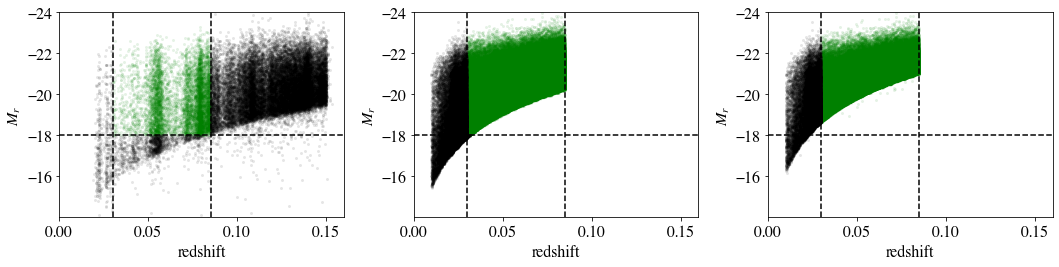

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plot_z_mag(gkgz_data['Z_TONRY'], gkgz_data['absmag_r'], gkgz_in_vol_limit, ax[0])
plot_z_mag(gz1_data['REDSHIFT'], gz1_data['MR'], gz1_in_vol_limit, ax[1])
plot_z_mag(gz2_data['REDSHIFT'], gz2_data['MR'], gz2_in_vol_limit, ax[2])
plt.tight_layout()
# THIS IS NOT PROPERLY VOLUME LIMITED (THERE IS A GAP) BECAUSE GZ2 HAD A BRIGHTER LIMIT THAN GZ1.
# YOU CAN ALSO SEE THAT THE GAMA DATA IS A LOT LESS NUMEROUS
# (DUE TO SMALLER AREA) BUT GOES ~2 MAG FAINTER.
# THE SDSS DENSITIES END AT Z=0.85, BUT GAMA CAN MEASURE THEM FURTHER OUT.

In [22]:
def Tfunction(p, x):
    p0, p1, q0, q1, q2 = p
    return p0 + p1*x + q0*np.tanh((x-q1)/q2) 

def Cur_divide_baldry06(logmstar):
    p = (2.18, 0, 0.38, 10.26, 0.85)
    return Tfunction(p, logmstar)

redness = gkgz_data['uminusr'] - Cur_divide_baldry06(gkgz_data['logmstar']) + 0.25
gkgz_data['red'] = redness > 0

gz1_data['red'] = gz1_data['REDNESS_BALDRY06'] > 0

gz2_data['red'] = gz2_data['REDNESS_BALDRY06'] > 0

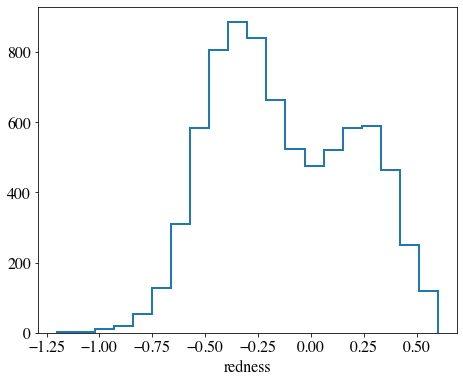

In [23]:
plt.hist(redness[gkgz_in_vol_limit], histtype='step', lw=2, range=(-1.2, 0.6), bins=20)
plt.xlabel('redness');

In [24]:
def plot_col_mass(table, in_vol_limit, logmstar='logmstar', uminusr='uminusr', red='red'):
    fig, ax = plt.subplots()
    alpha = min(1, 2000/len(table[in_vol_limit]))
    ax.scatter(table[logmstar][~in_vol_limit], table[uminusr][~in_vol_limit],
               marker='.', c='k', edgecolors='none', alpha=alpha/20.0)
    ax.scatter(table[logmstar][in_vol_limit], table[uminusr][in_vol_limit],
               c=table[red][in_vol_limit], cmap='jet', marker='.', edgecolors='none', alpha=alpha)
    ax.vlines(9.5, 0.2, 3.0, colors='k', linestyles=':')
    ax.set_xlabel(r'$\log\,{M_{\star}}$')
    ax.set_ylabel(r'restframe ($u-r$)')
    ax.set_ylim(0.2, 3.0)
    ax.set_xlim(8.2, 11.7)

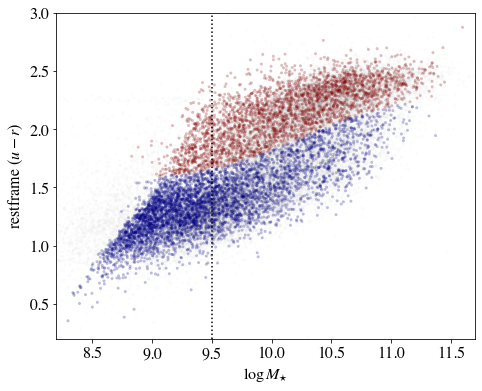

In [25]:
plot_col_mass(gkgz_data, gkgz_in_vol_limit)

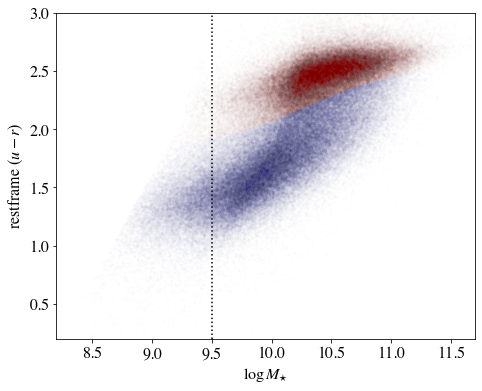

In [26]:
plot_col_mass(gz1_data, gz1_in_vol_limit, 'LOGMSTAR_BALDRY06', 'CUR')

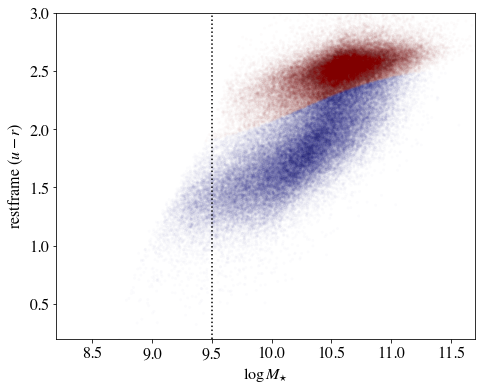

In [27]:
plot_col_mass(gz2_data, gz2_in_vol_limit, 'LOGMSTAR_BALDRY06', 'CUR')

In [28]:
gkgz_vol_table = gkgz_data[gkgz_in_vol_limit]
print(len(gkgz_vol_table))

7890


In [29]:
gz1_vol_table = gz1_data[gz1_in_vol_limit]
print(len(gz1_vol_table))

228116


In [30]:
gz2_vol_table = gz2_data[gz2_in_vol_limit]
print(len(gz2_vol_table))

125684


In [31]:
gkgz_vol_table['logSurfaceDensity'] = np.log10(gkgz_vol_table['SurfaceDensity'])

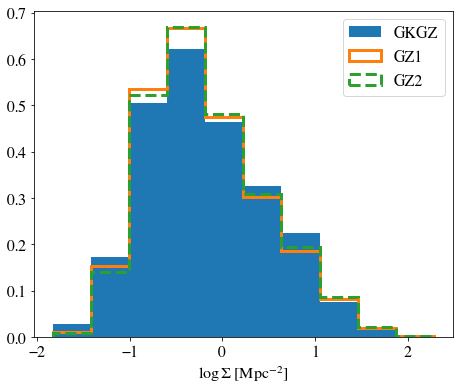

In [32]:
counts, bins, p = plt.hist(gkgz_vol_table['logSurfaceDensity'],
                           density=True, label='GKGZ')
plt.hist(gz1_vol_table['IVAN_DENSITY'], bins=bins,
         histtype='step', lw=3, density=True, label='GZ1')
plt.hist(gz2_vol_table['IVAN_DENSITY'], bins=bins,
         histtype='step', lw=3, ls="--", density=True, label='GZ2')
plt.xlabel('$\log\,\Sigma\;[\mathrm{Mpc^{-2}}]$')

plt.legend();

In [33]:
def get_errors(p, n):
    k = n * p
    # if k is not an integer, need to set it to an integer
    # to be sure that confidence inverval contains p
    low, _ = binom_conf_interval(np.floor(k), n)
    _, high = binom_conf_interval(np.ceil(k), n)
    low_err = p - low
    high_err = high - p
    interval = (low, high)
    error = (low_err, high_err)
    return interval, error

In [34]:
def bin_data(table, n_bins, column, limits):
    counts, bins = np.histogram(table[column], bins=n_bins, range=limits)
    table['bins']= np.digitize(table[column], bins)
    grouped= table.group_by('bins')
    binned = grouped.groups.aggregate(np.mean)
    counts = grouped['bins'].groups.aggregate(len)
    ok_bins = (binned['bins'] > 0) & (binned['bins'] <= n_bins)
    binned = binned[ok_bins]
    counts = counts[ok_bins]
    return binned, counts

In [35]:
def plot_env_all_masses(vol_table,
                        n_env_bins=10,
                        env='logSurfaceDensity', 
                        env_label=r'$\log_{10}\left(\Sigma\,[\mathrm{Mpc}^{-2}]\right)$',
                        env_limits=[-1.5, 1.75],
                        morph='p_spiral',
                        red='red'):

    binned, n_bins = bin_data(vol_table, n_env_bins, env, env_limits)
    if red:
        p_red = binned[red]
        interval_red, error_red = get_errors(p_red, n_bins)
    if morph:
        p_el = 1 - binned[morph]
        interval_el, error_el = get_errors(p_el, n_bins)

    plt.xlabel(env_label)
    
    label = []
    if red:
        label.append(r'f_{\mathrm{red}}')
    if morph:
        label.append(r'f_{\mathrm{el}}')
    label = '$' + r',\ '.join(label) + '$'
    plt.ylabel(label)
    
    if red:
        plt.plot(binned[env], p_red, 'o--', label='red', color='purple')
        plt.fill_between(binned[env], interval_red[0], interval_red[1], alpha=0.25,
                         linewidth=0, color='purple')

    if morph:
        plt.plot(binned[env], p_el, 'o-', label='el', color='green')
        plt.fill_between(binned[env], interval_el[0], interval_el[1], alpha=0.25, linewidth=0,
                        color='green')

    plt.legend(loc='upper left');
    plt.axis(ymin=0, ymax=1)
    #plt.xaxis.set_tick_params(which='minor',  direction='in', top='on')

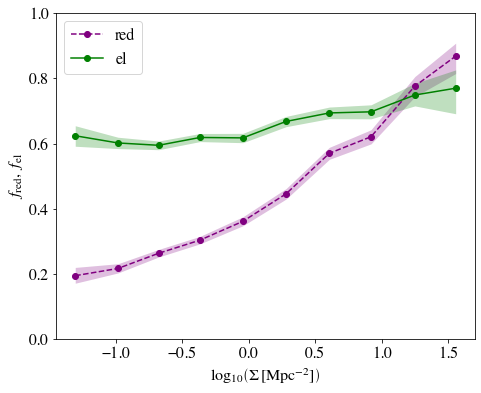

In [36]:
plot_env_all_masses(gkgz_vol_table, 10, 'logSurfaceDensity',
                    env_limits=[-1.5, 1.75],
                    morph='p_spiral')

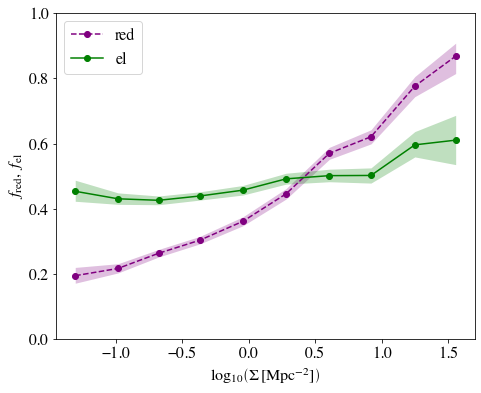

In [37]:
plot_env_all_masses(gkgz_vol_table, 10, 'logSurfaceDensity',
                    env_limits=[-1.5, 1.75],
                    morph='p_disk')

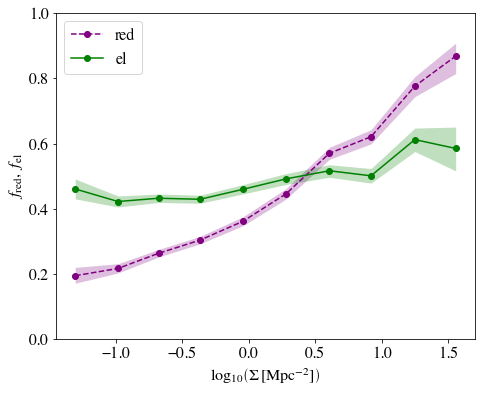

In [38]:
plot_env_all_masses(gkgz_vol_table, 10, 'logSurfaceDensity',
                    env_limits=[-1.5, 1.75],
                    morph='disk')

In [39]:
Image(url="bamford09/fig8_left.png", width=475)

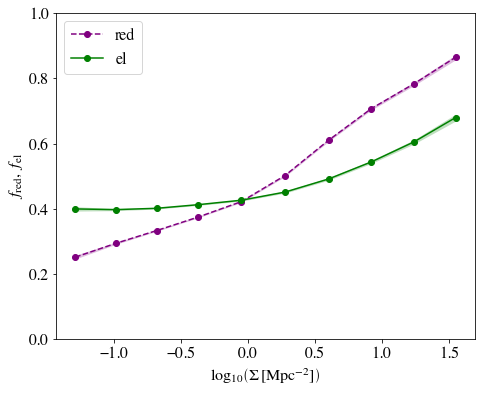

In [40]:
plot_env_all_masses(gz1_vol_table, 10, 'IVAN_DENSITY',
                    env_limits=[-1.5, 1.75],
                    morph='p_disk')

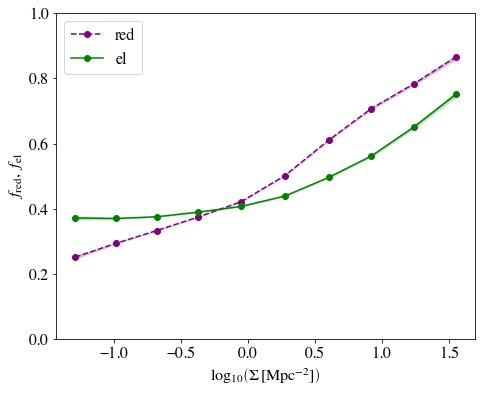

In [41]:
plot_env_all_masses(gz1_vol_table, 10, 'IVAN_DENSITY',
                    env_limits=[-1.5, 1.75],
                    morph='disk')

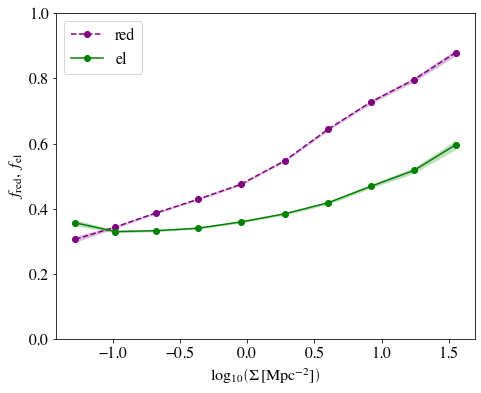

In [42]:
plot_env_all_masses(gz2_vol_table, 10, 'IVAN_DENSITY',
                    env_limits=[-1.5, 1.75],
                    morph='p_disk')

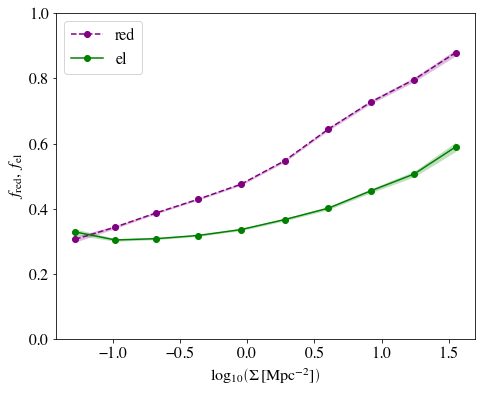

In [43]:
plot_env_all_masses(gz2_vol_table, 10, 'IVAN_DENSITY',
                    env_limits=[-1.5, 1.75],
                    morph='disk')

In [44]:
def plot_mass_bins(vol_table,
                   n_mass_bins=9,
                   mass_limits=[9.5, 11.3],
                   show_mass_bins=[2, 4, 6, 8],
                   n_env_bins=6,
                   env='logSurfaceDensity', 
                   env_label=r'$\log_{10}\left(\Sigma\,[\mathrm{Mpc}^{-2}]\right)$',
                   env_limits=[-1.5, 1.75],
                   mass='logmstar',
                   morph='spiral',
                   red='red'):
    
    counts, bins = np.histogram(vol_table[mass], bins=n_mass_bins, range=mass_limits)
    vol_table['mass_bins']= np.digitize(vol_table[mass], bins)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    ax1.set_xlabel(env_label)
    ax2.set_xlabel(env_label)
    ax1.set_ylabel('$f_{\mathrm{el}}$')
    ax2.set_ylabel('$f_{\mathrm{red}}$')

    #environmental bins
    #for all mass bins group by galaxy density
    for x in show_mass_bins:
        in_mass_bin = vol_table['mass_bins'] == x
        mass_bin_table = vol_table[in_mass_bin]
        n_in_mass_bin = len(mass_bin_table)

        if n_in_mass_bin > 10:
            means, n = bin_data(mass_bin_table, n_env_bins, env, limits=env_limits)

            p_red = means[red]
            interval_red, error_red = get_errors(p_red, n)

            p_el = 1 - means[morph]
            interval_el, error_el = get_errors(p_el, n)
            
            mass_label = f'{(bins[x-1]+bins[x])/2:.1f}'
            ax1.plot(means[env], p_el, '.-', label=mass_label)
            ax1.fill_between(means[env], interval_el[0], interval_el[1],
                             alpha=0.25, linewidth=0)

            ax2.plot(means[env], p_red, '.--', label=mass_label)
            ax2.fill_between(means[env], interval_red[0], interval_red[1],
                             alpha=0.25, linewidth=0)

    ax2.legend(loc='lower right')    
    ax1.set_ylim(ymin=0, ymax=1)
    ax2.set_ylim(ymin=0, ymax=1)

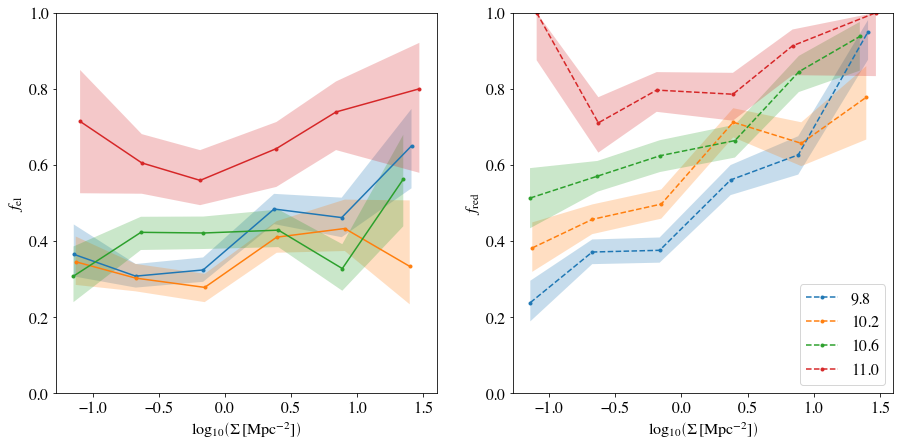

In [45]:
plot_mass_bins(gkgz_vol_table, morph='disk')

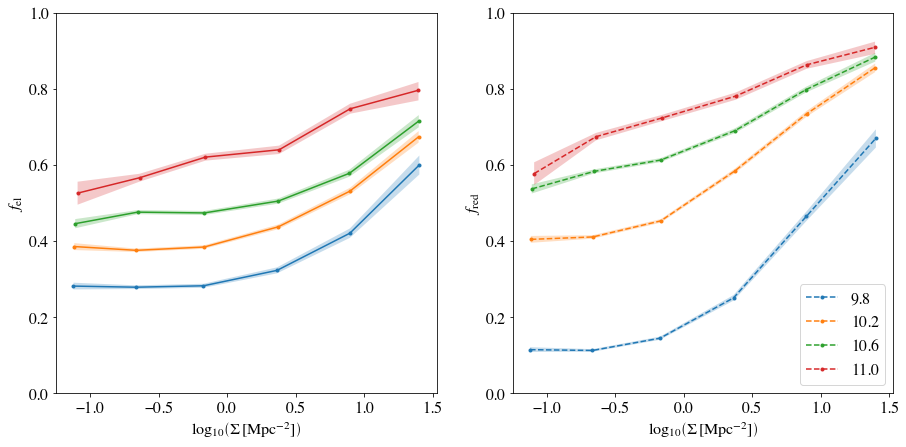

In [46]:
plot_mass_bins(gz1_vol_table, morph='disk', env='IVAN_DENSITY', mass='LOGMSTAR_BALDRY06')

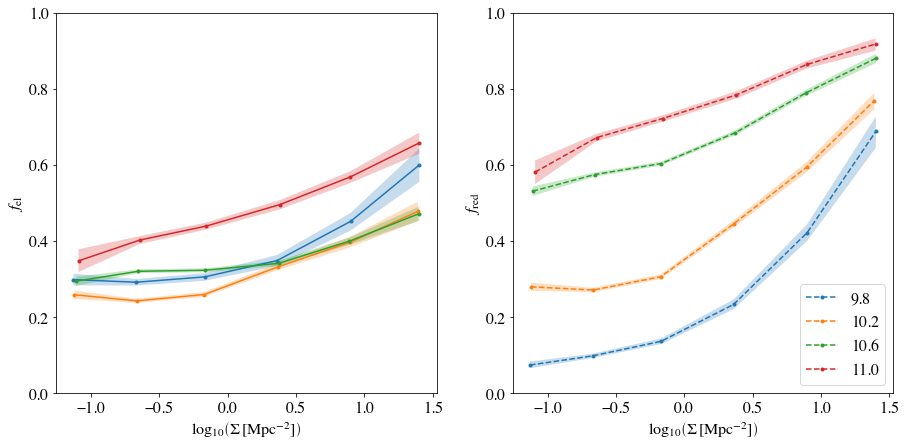

In [47]:
plot_mass_bins(gz2_vol_table, morph='disk', env='IVAN_DENSITY', mass='LOGMSTAR_BALDRY06')